## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

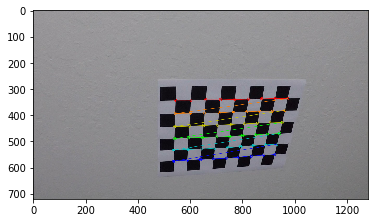

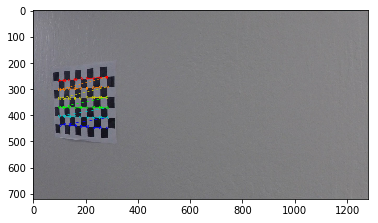

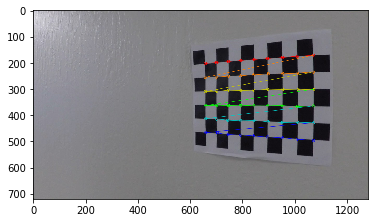

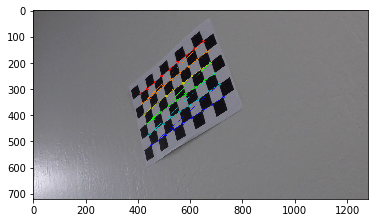

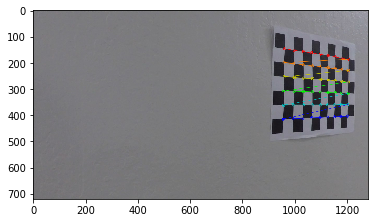

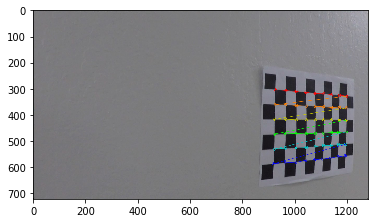

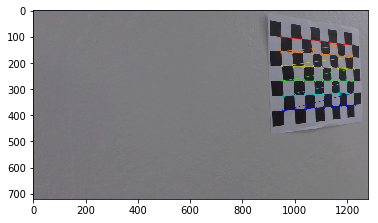

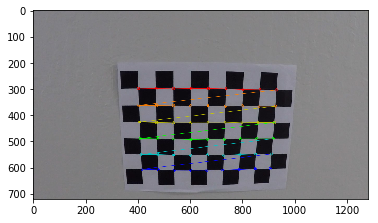

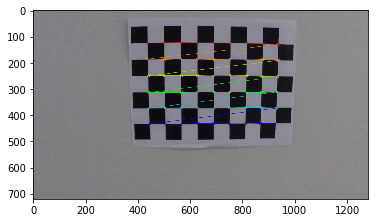

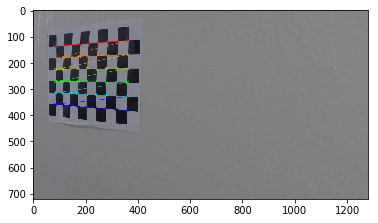

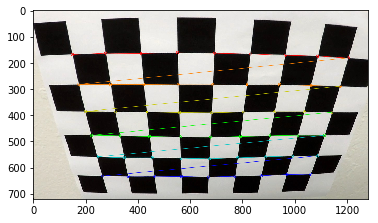

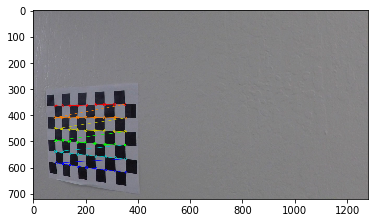

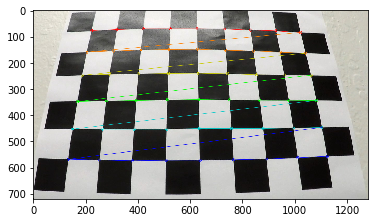

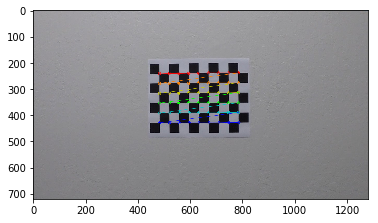

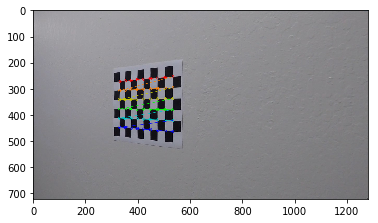

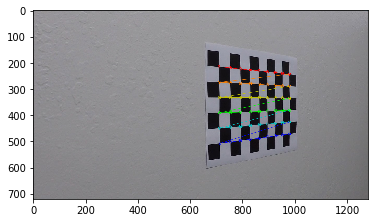

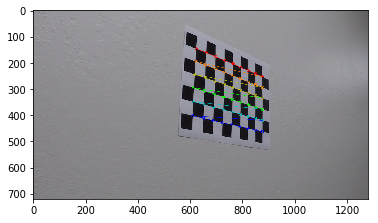

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img.astype('uint8'))
        plt.show()

## And so on and so forth...

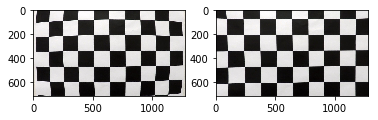

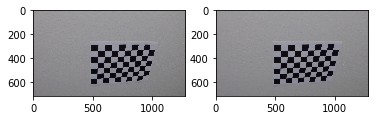

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)

# Perform the image distortion correction
for fname in images[:2]:
    # Read image and undistort
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert BRG 2 RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    # Perform the camera calibration
    
    # Display images and undistored images
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(img.astype('uint8'))
    fig.add_subplot(1, 2, 2)
    plt.imshow(undist.astype('uint8'))
    plt.show()

In [3]:
def get_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Get binary image
    binary = np.zeros_like(sxbinary)
    binary[sxbinary == 1] = 1
    binary[s_binary == 1] = 1
    
    return binary

In [4]:
src = np.float32([[585, 460], [700, 460], [220, 720], [1060, 720]])
dst = np.float32([[260, 0], [1020, 0], [260, 720], [1020, 720]])

M = cv2.getPerspectiveTransform(src, dst)
def perspective_transform(im):
    img_size = (im.shape[1], im.shape[0])
    warped = cv2.warpPerspective(im, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

Minv = cv2.getPerspectiveTransform(dst, src)
def perspective_transform_inverse(im):
    img_size = (im.shape[1], im.shape[0])
    warped = cv2.warpPerspective(im, Minv, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [5]:
def perspective_transform_inverser_pos(x, y):
    re = np.matmul(Minv, np.array([x, y, 1]))
    newx, newy = int(re[0]/re[2]), int(re[1]/re[2])
    return newx, newy

In [6]:
def sliding_win(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    points_left = [[x, y] for x,y in zip(left_fitx, ploty)]
    cv2.polylines(out_img, np.int32([points_left]), 0, (0, 255, 255), 10)
    
    points_right = [[x, y] for x,y in zip(right_fitx, ploty)]
    cv2.polylines(out_img, np.int32([points_right]), 0, (0, 255, 255), 10)
    
    return out_img, [left_fitx, right_fitx, ploty], [leftx, lefty, rightx, righty]

In [7]:
def calculate_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    y_eval = 720
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad + right_curverad)/2.
    return curvature

In [8]:
def calculate_dis2center(left_fitx, right_fitx):
    leftx = left_fitx[-1]
    rightx = right_fitx[-1]
    width = rightx - leftx
    center = (leftx + rightx) / 2
    dis = (720 - center)
    dis = (dis / width ) * 3.7
    return dis

In [9]:
def drawing(undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    # warp_zero = np.zeros_like(warped).astype(np.uint8)
    # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros_like(undist)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform_inverse(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [10]:
# put curvature and distance2center on frame
def display_info(img, curvature, dis):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Curvature is {:.2f}m.'.format(curvature), (10,30), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(img, 'Dis2Center is {:.2f}m.'.format(dis), (10, 65), font, 1, (255,255,255), 2, cv2.LINE_AA)
    return img

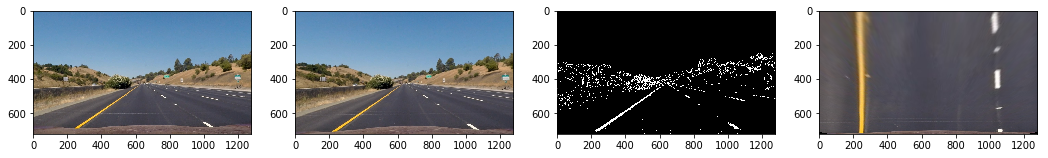

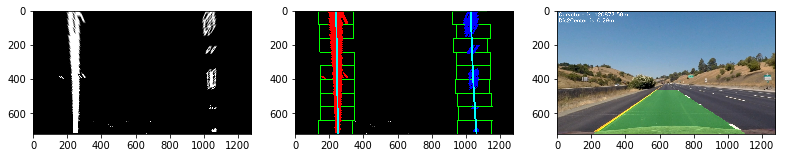

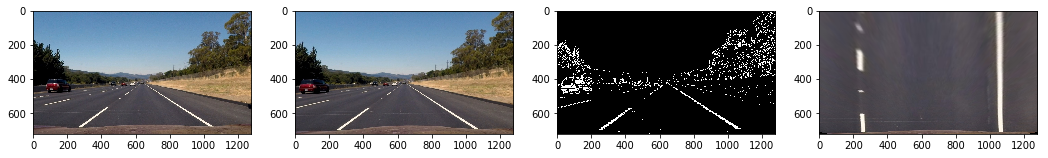

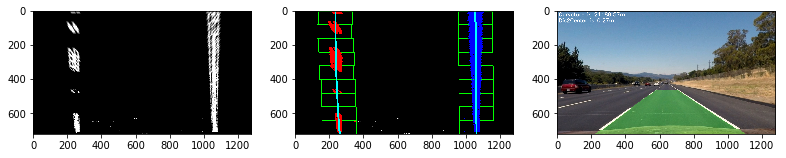

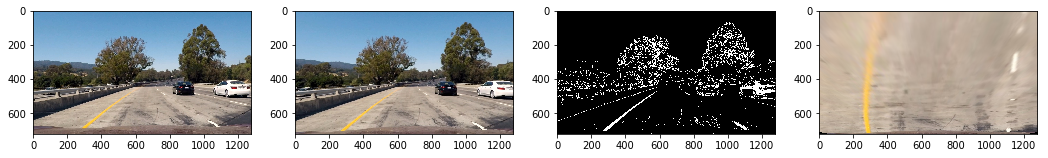

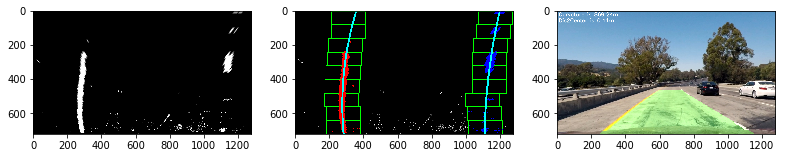

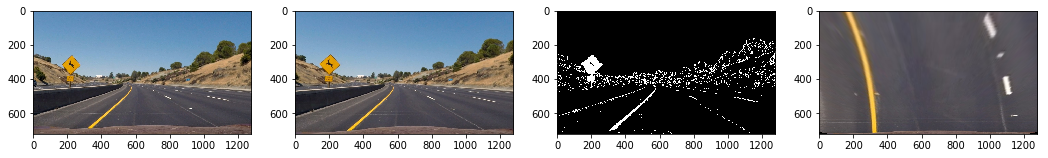

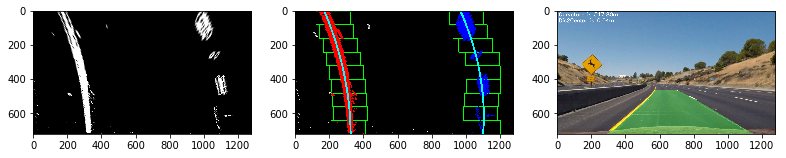

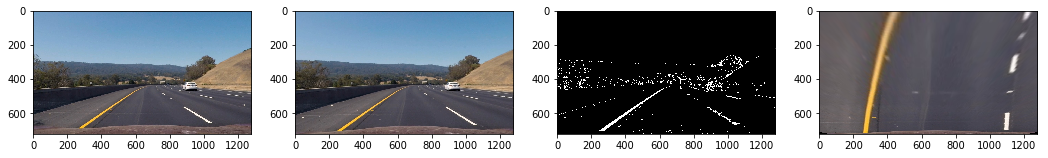

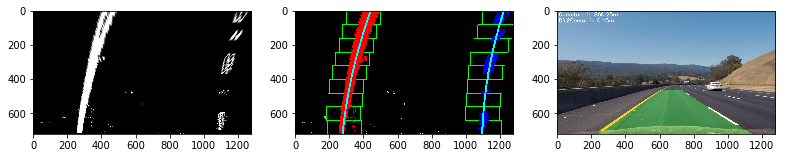

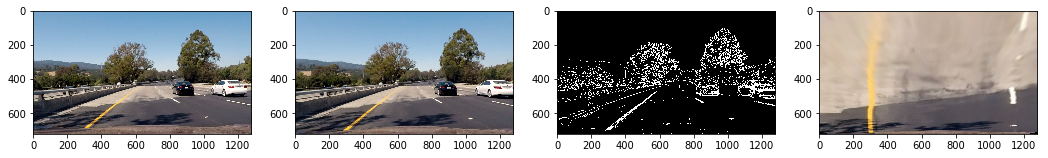

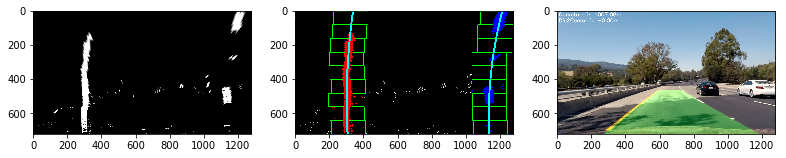

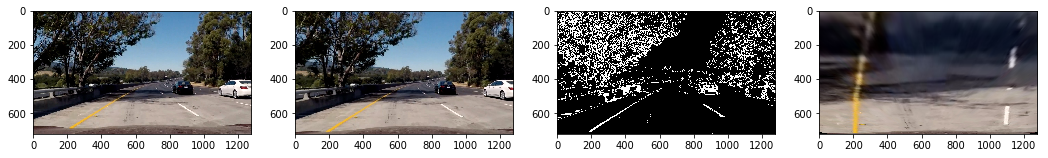

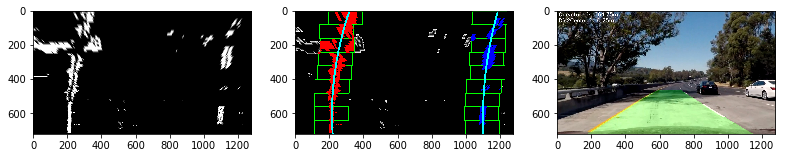

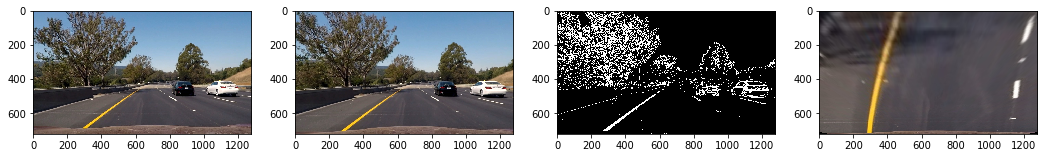

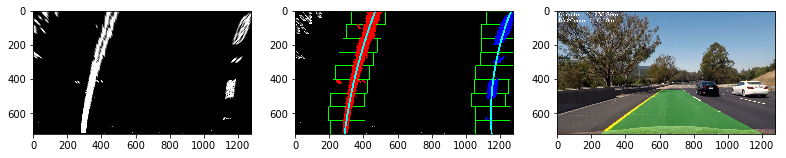

In [11]:
# Make a list of calibration images
images = glob.glob('./test_images/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    # Read image and undistort
    img = cv2.imread(fname)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert BRG 2 RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    
    # Get binary image
    bi = get_binary(undist)
    bi = np.uint8(255*bi)
    
    # Display images and undistored images
    fig = plt.figure(figsize=(18, 36))
    
    fig.add_subplot(1, 4, 1)
    plt.imshow(img.astype('uint8'))
    
    fig.add_subplot(1, 4, 2)
    plt.imshow(undist.astype('uint8'))
    
    fig.add_subplot(1, 4, 3)
    plt.imshow(bi, cmap='gray')
    
    warped = perspective_transform(undist)
    fig.add_subplot(1, 4, 4)
    plt.imshow(warped)
    
    plt.show()
    fig = plt.figure(figsize=(18, 36))
    
    warped_bi = perspective_transform(bi)
    fig.add_subplot(1, 4, 1)
    plt.imshow(warped_bi, cmap='gray')
    
    lane_img, [left_fitx, right_fitx, ploty], [leftx, lefty, rightx, righty] = sliding_win(warped_bi)
    fig.add_subplot(1, 4, 2)
    plt.imshow(lane_img)
    
    # calculate curvature and distance to center
    curvature = calculate_curvature(leftx, lefty, rightx, righty)
    dis2center = calculate_dis2center(left_fitx, right_fitx)
    
    final_img = drawing(undist, left_fitx, right_fitx, ploty)
    final_img = display_info(final_img, curvature, dis2center)
    fig.add_subplot(1, 4, 3)
    plt.imshow(final_img)
    
    plt.show()

## Test on Videos

In [12]:
def pipline(im):
    # lane detection and fit curve
    undist = cv2.undistort(im, mtx, dist, None, mtx)
    bi = get_binary(undist)
    bi = np.uint8(255*bi)
    warped_bi = perspective_transform(bi)
    
    lane_img, [left_fitx, right_fitx, ploty], rawpoints = sliding_win(warped_bi)
    leftx, lefty, rightx, righty = rawpoints
    
    # calculate curvature and distance to center
    curvature = calculate_curvature(leftx, lefty, rightx, righty)
    dis2center = calculate_dis2center(left_fitx, right_fitx)
    
    # draw
    final_img = drawing(undist, left_fitx, right_fitx, ploty)
    final_img = display_info(final_img, curvature, dis2center)
    return final_img

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
out_clip = clip1.fl_image(pipline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:30<00:00,  7.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 19s, sys: 24.9 s, total: 3min 44s
Wall time: 3min 32s


In [15]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(video_output))